# 1. Import necessary packages

In [180]:
import os

import turmoric
from turmoric.image_process import nd2_to_tif
from turmoric.utils import recursively_get_all_filepaths
from turmoric.apply_thresholds import apply_all_thresh

from pathlib import Path

import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import filters, io
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects
from skimage.measure import block_reduce, label, regionprops
from skimage import exposure
from scipy import ndimage

from turmoric.cell_analysis import apply_regionprops_recursively
from turmoric.utils import organize_files_without_leakage

from PIL import Image

from sklearn.model_selection import train_test_split
import shutil

import vampire

# 2. If images are saved as ND2 files, convert to TIFs

In [17]:
path_to_nd2s = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data" # Put in the path to the directory that holds your images here


file_list = recursively_get_all_filepaths(path_to_nd2s, file_type="nd2")

for file in file_list:

    path_name = Path(file)  
    file_name = os.path.basename(file)
    #nd2_to_tif(path_name.parent, file_name)
    

# 3. Determine the best thresholding method

#### This section is possibly the most important part of this entire process, as it determines the quality of data used for analysis. We will be tuning a few different parameters, namely:

1. The threshold method being used
2. the minimum size for excluding objects in the image, which are likely imaging artifacts and not cells
3. The maximum size for exluding objects from the image; large objects are likely overlapping cells that the thresholding method cannot correctly seperate into multiple objects

#### The goal of this process is to minimize the background in the image while including as many real individual cells as possible

In [79]:
path_to_tifs = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/Opt"
tif_files = recursively_get_all_filepaths(path_to_tifs, file_type='tif')

#### First, we will try 7 different thresholding methods to see if any are clearly are best at seperating out cells. The "apply_all_thresh" function will apply 7 threshold methods to each image in the folder you pass it, and then save an image file that shows the original image and the thresholded images on the same figure in the second folder given. You must also tell the function which channel of the image the cells of interest are in. 

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/nelsschimek/.local/share/mamba/envs/vampire/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/x0/30gk1h9n3fqfnt97pwz4bw380000gn/T/ipykernel_30644/3573001998.py", line 1, in <module>
    apply_all_thresh(path_to_tifs, path_to_tifs, 1)
  File "/Users/nelsschimek/Documents/nancelab/software_packages/TURMorIC/src/turmoric/apply_thresholds.py", line 108, in apply_all_thresh
    ax[i].imshow(func(microglia_im))
                 ^^^^^^^^^^^^^^^^^^
  File "/Users/nelsschimek/Documents/nancelab/software_packages/TURMorIC/src/turmoric/apply_thresholds.py", line 68, in wrapper
    return im > func(im)
                ^^^^^^^^
  File "/Users/nelsschimek/.local/share/mamba/envs/vampire/lib/python3.11/site-packages/skimage/filters/thresholding.py", line 871, in threshold_minimum
    maximum_idxs = find_local_maxima_idx(smooth_hist)
        

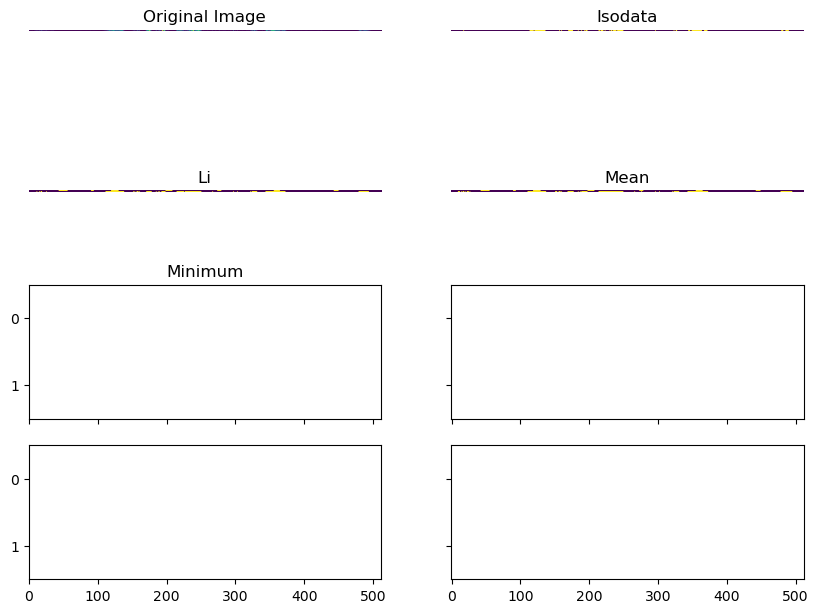

In [66]:
apply_all_thresh(path_to_tifs, path_to_tifs, 1)

#### After looking through the images, there should be 1-3 thresholds that are best at capturing the cells in the original image. We will now look at the minimize and maximum object size parameters

In [92]:
def create_microglia_mask(image, threshold_method=filters.threshold_li):
    print(image.shape)
    image = image[1,:,:]
    print(image.shape)

    thresh_li = threshold_method(image)
    binary_li = image > thresh_li

    objects = label(binary_li)
    objects = clear_border(objects)
    large_objects = remove_small_objects(objects, min_size=50000)
    small_objects = label((objects ^ large_objects) > thresh_li)

    binary_li = ndimage.binary_fill_holes(remove_small_objects(small_objects > thresh_li, min_size=250))

    #scaled_img = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype('uint8')
    #hist = np.histogram(scaled_img.flatten(), range=[0,50], bins=50)
    return binary_li

In [119]:
cell_images = [tiff.imread(f) for f in sorted(tif_files)]


In [120]:
mean_masks = [create_microglia_mask(f, threshold_method=filters.threshold_mean) for f in cell_images]
li_masks = [create_microglia_mask(f, threshold_method=filters.threshold_li) for f in cell_images]
#otsu_masks = [create_microglia_mask(f, threshold_method=filters.threshold_otsu) for f in cell_images]
#isodata_masks = [create_microglia_mask(f, threshold_method=filters.threshold_isodata) for f in cell_images]

(3, 512, 512)
(512, 512)
(3, 512, 512)
(512, 512)
(3, 1024, 1024)
(1024, 1024)
(3, 1024, 1024)
(1024, 1024)
(3, 512, 512)
(512, 512)
(3, 512, 512)
(512, 512)
(3, 1024, 1024)
(1024, 1024)
(3, 1024, 1024)
(1024, 1024)


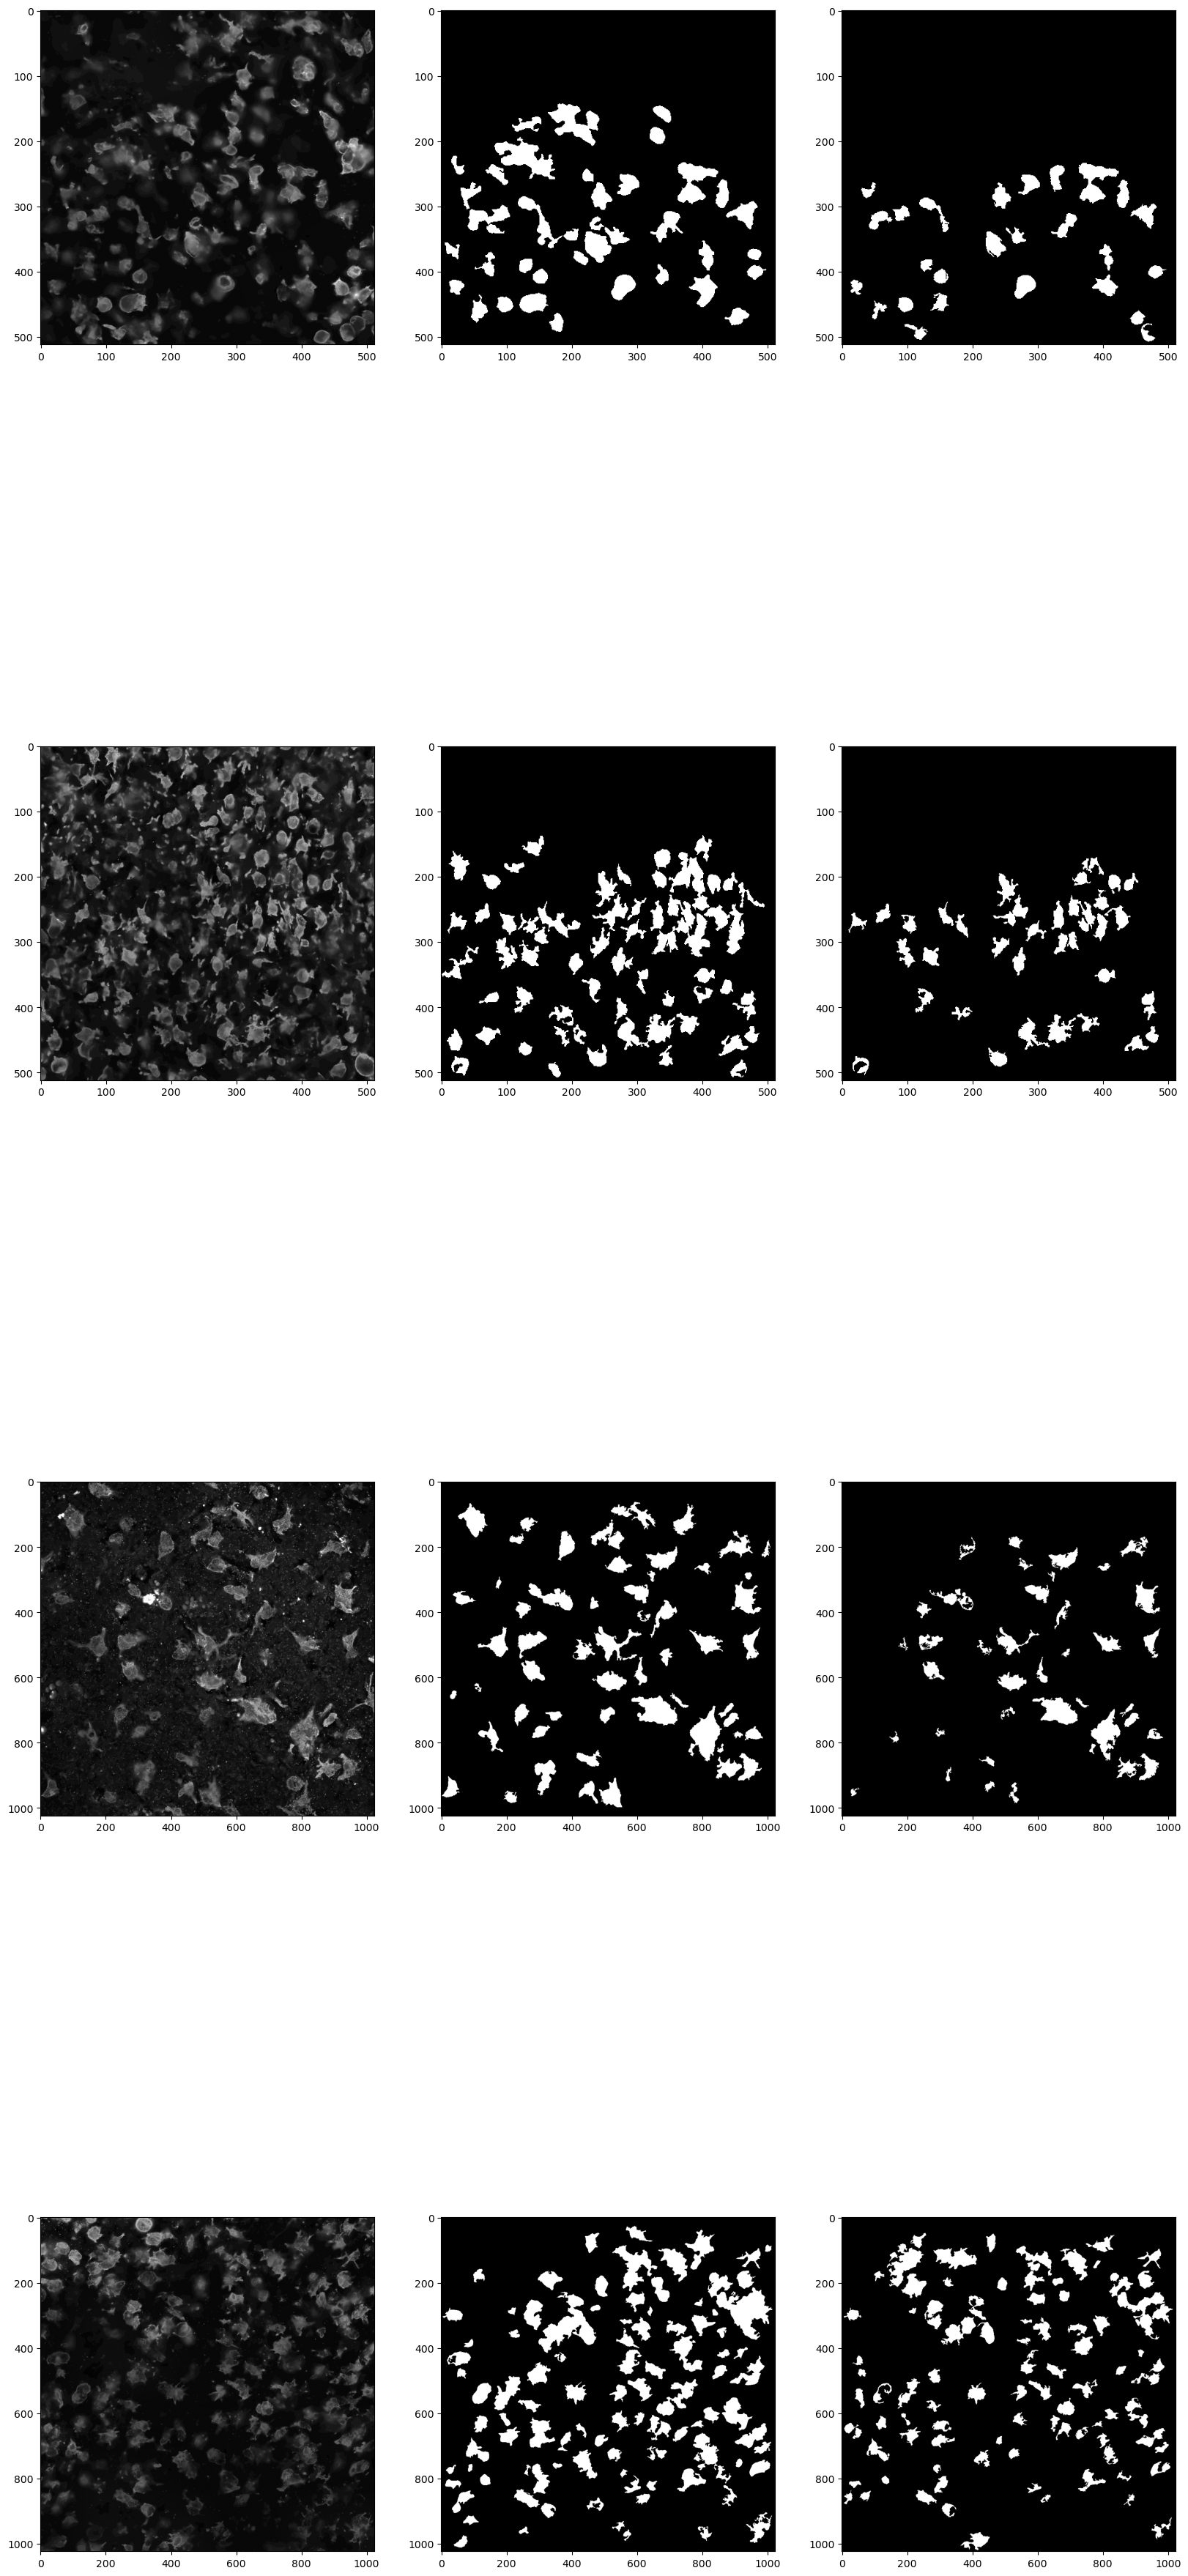

In [121]:
columns = 3
rows = 5#len(li_masks)

fig, axes = plt.subplots(len(li_masks), columns, figsize=(20, 50))
for ax, original, li, mean in zip(axes, cell_images, li_masks, mean_masks):

    raw_image = original[1,:,:]
    enhanced_im = exposure.equalize_adapthist(raw_image, clip_limit=0.03)
    ax[0].imshow(enhanced_im, cmap="gray")
    ax[1].imshow(mean, cmap="gray")
    ax[2].imshow(li, cmap="gray")

# 4. Applying chosen threshold to all images

In [124]:
def apply_li_threshold(input_folder, output_folder, channel, size):
    """
    Applies Li thresholding to all .tif images in the input folder
    (and subfolders)
    and saves the binary masks in the output folder.

    Parameters:
    - input_folder: Path to the folder containing .tif images.
    - output_folder: Path to save the processed binary masks.
    - size: Minimum size of objects to retain in the binary mask.
    """
    if not os.path.isdir(input_folder):
        print(f"Error: Input folder '{input_folder}' does not exist.")
        return

    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Walk through all files and subfolders
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith(".tif"):
                # Full input path
                input_path = os.path.join(root, file)

                # Create corresponding output subfolder
                relative_path = os.path.relpath(root, input_folder)
                output_subfolder = os.path.join(output_folder, relative_path)
                os.makedirs(output_subfolder, exist_ok=True)

                # Full output path
                output_path = os.path.join(output_subfolder,
                                           file.replace(".tif",
                                                        "_li_thresh.npy"))

                try:
                    # Read the image
                    img = io.imread(input_path)

                    # Assume the second channel is the microglia channel
                    # if img.ndim == 3:
                    #     microglia_im = img[:, :, 1]
                    # elif img.ndim == 2:
                    #     microglia_im = img[1, :, :]
                    # else:
                    #     microglia_im = img

                    microglia_im = img[channel, :, :]

                    # Apply Li threshold


                    # img = tiff.imread(input_path)
                    
                    binary_li = create_microglia_mask(microglia_im)

                        # Save the binary mask as .npy
                    np.save(output_path, binary_li)
                        

                except Exception as e:
                    print(f"Error processing {input_path}: {e}")

    print(f"Processing completed. Results are saved in '{output_folder}'.")


In [147]:
input_folder = ""
thresholded_images = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/li_thresh/"

apply_li_threshold(input_folder=input_folder, output_folder=thresholded_images, channel=1, size=73)

Error: Input folder '' does not exist.


In [148]:
props_list = ('area', 'bbox_area', 'centroid', 'convex_area',
              'eccentricity', 'equivalent_diameter', 'euler_number',
              'extent', 'filled_area', 'major_axis_length',
              'minor_axis_length', 'orientation', 'perimeter', 'solidity')

In [153]:
regionprops_df = apply_regionprops_recursively(input_folder=thresholded_images, properties_list=props_list)
regionprops_df['circularity'] = 4*np.pi*regionprops_df.area/regionprops_df.perimeter**2
regionprops_df['aspect_ratio'] = regionprops_df.major_axis_length/regionprops_df.minor_axis_length
regionprops_df.head()


,area,bbox_area,centroid-0,centroid-1,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,solidity,filename,circularity,aspect_ratio
0,612.0,1110.0,417.186275,231.705882,792.0,0.809676,27.914559,1,0.551351,612.0,38.307131,22.481590,0.498931,129.604076,0.772727,/Users/nelsschimek/Documents/nancelab/Data/gab...,0.457851,1.703933
1,591.0,1280.0,38.453469,409.964467,881.0,0.826481,27.431452,1,0.461719,591.0,39.458818,22.213911,0.336429,166.539105,0.670829,/Users/nelsschimek/Documents/nancelab/Data/gab...,0.267772,1.776311
2,1646.0,3657.0,196.444714,418.469623,2453.0,0.878622,45.779387,1,0.450096,1646.0,73.014862,34.865941,0.401790,298.320851,0.671015,/Users/nelsschimek/Documents/nancelab/Data/gab...,0.232419,2.094160
3,753.0,2124.0,197.110226,474.847278,1498.0,0.940229,30.963678,1,0.354520,753.0,72.249726,24.604153,-1.271864,252.421356,0.502670,/Users/nelsschimek/Documents/nancelab/Data/gab...,0.148509,2.936485
4,1327.0,3233.0,231.284853,56.398644,2078.0,0.852857,41.104609,1,0.410455,1327.0,68.629024,35.834258,-1.151247,350.948268,0.638595,/Users/nelsschimek/Documents/nancelab/Data/gab...,0.135392,1.915179


In [152]:
regionprops_df.to_csv("gaby_testing_csv.csv", index=False)

In [154]:

def convert_npy_to_tif_recursive(input_dir, output_dir):
    """
    Recursively convert all .npy files to .tif files while maintaining directory structure.
    
    Parameters:
    -----------
    input_dir : str or Path
        Root directory containing .npy files
    output_dir : str or Path
        Root directory where .tif files will be saved
    
    Returns:
    --------
    int : Number of files converted
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    if not input_path.exists():
        raise ValueError(f"Input directory does not exist: {input_dir}")
    
    # Create output directory if it doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)
    
    converted_count = 0
    
    # Walk through all subdirectories
    for npy_file in input_path.rglob("*.npy"):
        # Get relative path from input directory
        relative_path = npy_file.relative_to(input_path)
        
        # Create corresponding output path with .tif extension
        output_file = output_path / relative_path.with_suffix('.tif')
        
        # Create subdirectories in output if they don't exist
        output_file.parent.mkdir(parents=True, exist_ok=True)
        
        try:
            # Load numpy array and save as TIFF
            data = np.load(npy_file)
            Image.fromarray(data).save(output_file)
            
            converted_count += 1
            print(f"Converted: {relative_path}")
            
        except Exception as e:
            print(f"Error converting {npy_file}: {str(e)}")
    
    print(f"\nConversion complete! {converted_count} files converted.")
    return converted_count


In [157]:
convert_npy_to_tif_recursive(input_dir="", output_dir="")


Conversion complete! 0 files converted.


0

In [160]:
# Define your base directory and target directories for training and testing
base_dir = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/"
train_dir = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/training"
test_dir = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing"

# Define a list of subfolder names or patterns to look for
treatment_conditions = ["Acet", "Amin", "HC", "Meth", "Opt"]
groups = ["converted_tiffs"]

# Create training and testing directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [176]:
def train_test_split_generic(base_dir, train_dir, test_dir, groups, treatment_conditions, test_size=0.2, split=True):
    for group in groups:
        for condition in treatment_conditions:
            condition_path = os.path.join(base_dir, group, condition)
            if not os.path.exists(condition_path):
                continue
            
            print(f'processing {group} {condition}')
            print(condition_path)
            files = os.listdir(condition_path)
            train_slices, test_slices = train_test_split(files, test_size=test_size)
            
            # Create subdirectories for training and testing
            train_subdir = os.path.join(train_dir, group, condition)
            test_subdir = os.path.join(test_dir, group, condition)
            os.makedirs(train_subdir, exist_ok=True)
            os.makedirs(test_subdir, exist_ok=True)
            
            # Process training files
            for file in train_slices:
                src_path = os.path.join(condition_path, file)
                
                if split:
                    # Load image and split into 4 quadrants
                    img = Image.open(src_path)
                    img_array = np.array(img)
                    h, w = img_array.shape
                    
                    # Split into 4 quadrants
                    quadrants = [
                        img_array[:h//2, :w//2],      # Top-left (quad1)
                        img_array[:h//2, w//2:],      # Top-right (quad2)
                        img_array[h//2:, :w//2],      # Bottom-left (quad3)
                        img_array[h//2:, w//2:]       # Bottom-right (quad4)
                    ]
                    
                    # Save each quadrant
                    filename_without_ext = os.path.splitext(file)[0]
                    ext = os.path.splitext(file)[1]
                    
                    for i, quad in enumerate(quadrants, 1):
                        new_filename = f"{filename_without_ext}_quad{i}{ext}"
                        Image.fromarray(quad).save(os.path.join(train_dir, new_filename))
                else:
                    # Just copy the file as is
                    shutil.copy(src_path, os.path.join(train_dir, file))
            
            # Process test files
            for file in test_slices:
                src_path = os.path.join(condition_path, file)
                
                if split:
                    # Load image and split into 4 quadrants
                    img = Image.open(src_path)
                    img_array = np.array(img)
                    h, w = img_array.shape
                    
                    # Split into 4 quadrants
                    quadrants = [
                        img_array[:h//2, :w//2],      # Top-left (quad1)
                        img_array[:h//2, w//2:],      # Top-right (quad2)
                        img_array[h//2:, :w//2],      # Bottom-left (quad3)
                        img_array[h//2:, w//2:]       # Bottom-right (quad4)
                    ]
                    
                    # Save each quadrant
                    filename_without_ext = os.path.splitext(file)[0]
                    ext = os.path.splitext(file)[1]
                    
                    for i, quad in enumerate(quadrants, 1):
                        new_filename = f"{filename_without_ext}_quad{i}{ext}"
                        Image.fromarray(quad).save(os.path.join(test_subdir, new_filename))
                else:
                    # Just copy the file as is
                    shutil.copy(src_path, os.path.join(test_subdir, file))

In [177]:
train_test_split_generic(base_dir=base_dir, train_dir=train_dir, test_dir=test_dir, groups=groups, treatment_conditions=treatment_conditions, test_size=0.2, split=True)

processing converted_tiffs Acet
/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/converted_tiffs/Acet
processing converted_tiffs Amin
/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/converted_tiffs/Amin
processing converted_tiffs HC
/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/converted_tiffs/HC
processing converted_tiffs Meth
/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/converted_tiffs/Meth
processing converted_tiffs Opt
/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/converted_tiffs/Opt


In [178]:
image_set_path = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/training"

vampire.extraction.extract_properties(image_set_path)

,filename,image_id,label,centroid-y,centroid-x,area,bbox_area,convex_area,filled_area,perimeter,...,major_axis_length,minor_axis_length,orientation,euler_number,eccentricity,solidity,extent,raw_contour,circularity,aspect_ratio
0,080825_acet6_carbo_DAPI_iba_40x_ctx1_DN_li_thr...,1,76,8.300613,180.503067,489.0,1296.0,885.0,489.0,155.710678,...,40.443894,21.857850,1.278365,2,0.841377,0.552542,0.377315,"[[9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18...",0.253444,1.850314
1,080825_acet6_carbo_DAPI_iba_40x_ctx1_DN_li_thr...,1,82,8.320628,101.533632,446.0,1000.0,652.0,446.0,133.633514,...,38.919251,24.527578,1.088023,1,0.776419,0.684049,0.446000,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",0.313844,1.586755
2,080825_acet6_carbo_DAPI_iba_40x_ctx1_DN_li_thr...,1,89,46.733799,228.639771,1574.0,4030.0,2575.0,1574.0,353.019336,...,58.542988,50.269050,0.503564,1,0.512531,0.611262,0.390571,"[[52, 53, 52, 53, 54, 55, 55, 54, 53, 52, 51, ...",0.158715,1.164593
3,080825_acet6_carbo_DAPI_iba_40x_ctx1_DN_li_thr...,1,101,45.626039,157.135734,722.0,1960.0,1258.0,722.0,229.338095,...,46.833629,29.742034,0.305351,1,0.772465,0.573927,0.368367,"[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...",0.172502,1.574661
4,080825_acet6_carbo_DAPI_iba_40x_ctx1_DN_li_thr...,1,108,131.478587,498.101713,934.0,2135.0,1772.0,934.0,224.888348,...,63.121697,34.387901,0.108823,1,0.838574,0.527088,0.437471,"[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, ...",0.232072,1.835579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153,080825_amin4_carbo_DAPI_iba_40x_mb5_li_thresh_...,151,125,344.868089,468.587779,1031.0,3168.0,1877.0,1031.0,291.942172,...,66.445285,34.569007,-0.384939,1,0.854006,0.549281,0.325442,"[[18, 19, 20, 21, 22, 23, 24, 25, 26, 26, 27, ...",0.152011,1.922106
1154,080825_amin4_carbo_DAPI_iba_40x_mb5_li_thresh_...,151,129,352.898762,302.904334,3230.0,5694.0,3891.0,3230.0,366.753355,...,77.287023,58.963121,0.968366,1,0.646504,0.830121,0.567264,"[[51, 51, 51, 52, 53, 54, 55, 56, 57, 57, 57, ...",0.301762,1.310769
1155,080825_amin4_carbo_DAPI_iba_40x_mb5_li_thresh_...,151,158,487.176614,341.019984,3703.0,10140.0,7481.0,3703.0,721.440692,...,143.710004,64.803389,1.322067,2,0.892558,0.494987,0.365187,"[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, ...",0.089405,2.217631
1156,080825_amin4_carbo_DAPI_iba_40x_mb5_li_thresh_...,151,163,491.639944,501.376934,711.0,1711.0,1119.0,711.0,170.775649,...,43.685394,27.762171,0.017400,3,0.772099,0.635389,0.415546,"[[25, 26, 27, 28, 28, 28, 28, 28, 28, 28, 28, ...",0.306357,1.573558


In [181]:
build_info_df = pd.DataFrame({
    'img_set_path': [image_set_path],
    'output_path': [image_set_path],
    'model_name': ['li'],
    'num_points': [50],
    'num_clusters': [5],
    'num_pc': [np.nan]
})

Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/training
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/training


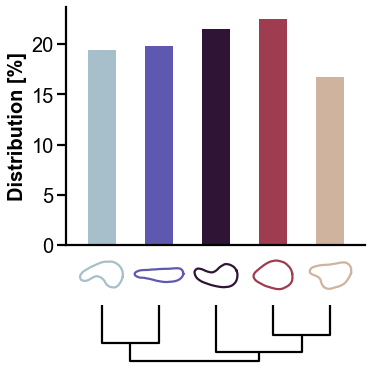

In [183]:
vampire.quickstart.fit_models(build_info_df)

In [184]:
model_path = os.path.join(image_set_path, 'model_li_(50_5_29)__.pickle')
vampire_model = vampire.util.read_pickle(model_path)

In [188]:

main_path = "/Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs"

apply_info_df = pd.DataFrame({
    'img_set_path': [
        f"{main_path}/Acet",
        f"{main_path}/Amin",
        f"{main_path}/HC",
        f"{main_path}/Meth",
        #f"{main_path}/Opt",
    
    ],
    'model_path': [model_path,
                   model_path,
                   model_path,
                   model_path,
                   #model_path
                   ],
                   
    'output_path': [
        f"{main_path}/Acet",
        f"{main_path}/Amin",
        f"{main_path}/HC",
        f"{main_path}/Meth",
        #f"{main_path}/Opt",
       
    ],
    'img_set_name': [
        "Acet",
        "Amin",
        "HC",
        "Meth",
        #"Opt",
    ],
})

Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/Acet
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/Acet
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/Amin
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/Amin
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/HC
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/HC
Contour and properties data already exist in path: /Users/nelsschimek/Documents/nancelab/Data/gaby_data/tifs/testing/converted_tiffs/Meth
Contour and properties data already ex

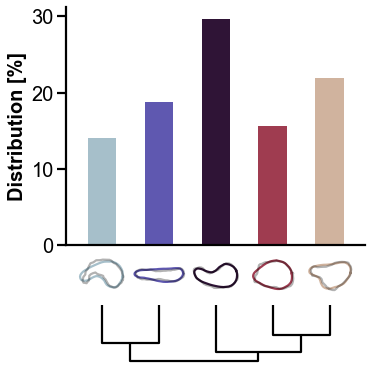

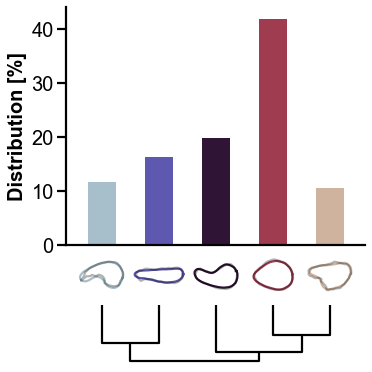

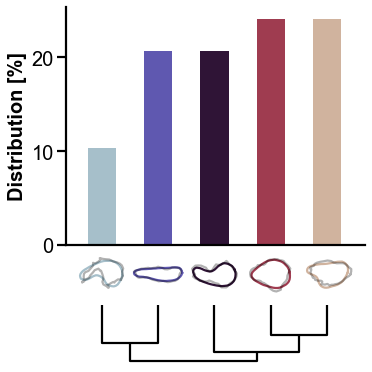

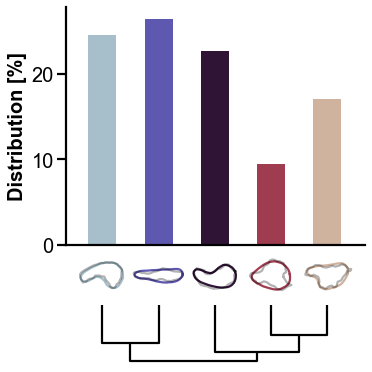

In [189]:
vampire.quickstart.transform_datasets(apply_info_df)